<a href="https://colab.research.google.com/github/Shubhrojit-Misra/Neuromatch/blob/main/tutorials/W3D1_TimeSeriesAndNaturalLanguageProcessing/student/W3D1_Tutorial1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial 1: Introduction to processing time series

**Week 3, Day 1: Time Series And Natural Language Processing**

**By Neuromatch Academy**

__Content creators:__ Lyle Ungar, Kelson Shilling-Scrivo, Alish Dipani

__Content reviewers:__ Kelson Shilling-Scrivo

__Content editors:__ Gagana B, Spiros Chavlis, Kelson Shilling-Scrivo

__Production editors:__ Gagana B, Spiros Chavlis

<br>

_Based on Content from: Anushree Hede, Pooja Consul, Ann-Katrin Reuel_

----
# Tutorial objectives

Before we explore how Recurrent Neural Networks (RNNs) excel at modeling sequences, we will explore other ways to model sequences, encode the text, and make meaningful measurements using such encodings and embeddings.

In [1]:
# @title Tutorial slides
from IPython.display import IFrame
link_id = "n263c"
print(f"If you want to download the slides: https://osf.io/download/{link_id}/")
IFrame(src=f"https://mfr.ca-1.osf.io/render?url=https://osf.io/{link_id}/?direct%26mode=render%26action=download%26mode=render", width=854, height=480)

If you want to download the slides: https://osf.io/download/n263c/


---
# Setup

In [2]:
# @title Install dependencies

# @markdown There may be *errors* and/or *warnings* reported during the installation. However, they are to be ignored.
!pip install nltk --quiet
!pip install fasttext --quiet
!pip install -U datasets --quiet
!pip install -U tokenizers --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 kB 4.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 494.8/494.8 kB 30.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 16.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-nvrtc-cu12==12.4.127; platform_system 

In [3]:
# @title Install and import feedback gadget

!pip3 install vibecheck datatops --quiet

from vibecheck import DatatopsContentReviewContainer
def content_review(notebook_section: str):
    return DatatopsContentReviewContainer(
        "",  # No text prompt
        notebook_section,
        {
            "url": "https://pmyvdlilci.execute-api.us-east-1.amazonaws.com/klab",
            "name": "neuromatch_dl",
            "user_key": "f379rz8y",
        },
    ).render()


feedback_prefix = "W3D1_T1"

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 28.8 MB/s eta 0:00:00


In [4]:
# Imports
import time
import nltk
import datasets
import fasttext
import tokenizers
import numpy as np
import matplotlib.pyplot as plt
from nltk.corpus import brown

import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split

In [5]:
# @title Figure Settings
import logging
logging.getLogger('matplotlib.font_manager').disabled = True

import ipywidgets as widgets
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/content-creation/main/nma.mplstyle")

In [6]:
# @title  Load Dataset from `nltk`
# No critical warnings, so we suppress it
import warnings
warnings.simplefilter("ignore")

nltk.download('brown')

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.


True

In [7]:
# @title Helper functions

# Gensim Word2Vec shim using fasttext
class Word2Vec:
   def __init__(self, sentences, vector_size=100, min_count=5, sg=1, workers=1):
     with open("sentences.txt", "w") as f:
       for sentence in sentences:
         f.write(" ".join(sentence) + "\n")
       self.wv = fasttext.train_unsupervised("sentences.txt",
                                             model='skipgram',
                                             dim=vector_size,
                                             minCount=min_count,
                                             thread=workers)
     def most_similar(word, topn=10):
       return [(n[1], n[0]) for n in self.wv.get_nearest_neighbors(word, k=topn)]
     self.wv.most_similar = most_similar

   def __str__(self):
     return self.wv.words

   def __iter__(self):
     for word in self.wv.words:
       yield word

# simple english tokenizer
def get_tokenizer(vocab):
  tokenizer_model = tokenizers.models.WordLevel(vocab, "<unk>")
  tokenizer = tokenizers.Tokenizer(tokenizer_model)
  tokenizer.normalizer = tokenizers.normalizers.BertNormalizer()
  tokenizer.pre_tokenizer = tokenizers.pre_tokenizers.BertPreTokenizer()
  return tokenizer

In [8]:
# @title Set random seed

# @markdown Executing `set_seed(seed=seed)` you are setting the seed

# For DL its critical to set the random seed so that students can have a
# baseline to compare their results to expected results.
# Read more here: https://pytorch.org/docs/stable/notes/randomness.html

# Call `set_seed` function in the exercises to ensure reproducibility.
import random
import torch

def set_seed(seed=None, seed_torch=True):
  """
  Function that controls randomness.
  NumPy and random modules must be imported.

  Args:
    seed : Integer
      A non-negative integer that defines the random state. Default is `None`.
    seed_torch : Boolean
      If `True` sets the random seed for pytorch tensors, so pytorch module
      must be imported. Default is `True`.

  Returns:
    Nothing.
  """
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')

# In case that `DataLoader` is used
def seed_worker(worker_id):
  """
  DataLoader will reseed workers following randomness in
  multi-process data loading algorithm.

  Args:
    worker_id: integer
      ID of subprocess to seed. 0 means that
      the data will be loaded in the main process
      Refer: https://pytorch.org/docs/stable/data.html#data-loading-randomness for more details

  Returns:
    Nothing
  """
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)

In [9]:
# @title Set device (GPU or CPU). Execute `set_device()`

# Inform the user if the notebook uses GPU or CPU.

def set_device():
  """
  Set the device. CUDA if available, CPU otherwise

  Args:
    None

  Returns:
    Nothing
  """
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("WARNING: For this notebook to perform best, "
        "if possible, in the menu under `Runtime` -> "
        "`Change runtime type.`  select `GPU` ")
  else:
    print("GPU is enabled in this notebook.")

  return device

In [10]:
DEVICE = set_device()
SEED = 2021
set_seed(seed=SEED)

Random seed 2021 has been set.


---
# Section 1: Intro: What time series are there?

*Time estimate: 20 mins*

In [11]:
# @title Video 1: Time Series and NLP
from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display


class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)


def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents


video_ids = [('Youtube', 'W4RTRXt7pO0'), ('Bilibili', 'BV1E94y117Nf')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

In [12]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Time_Series_and_NLP_Video")

In [13]:
# @title Video 2: What is NLP?
from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display


class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)


def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents


video_ids = [('Youtube', 'Q-PGZyaBQVk'), ('Bilibili', 'BV18v4y1M7GF')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

In [14]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_What_is_NLP_Video")

---
# Section 2: Embeddings

*Time estimate: 50 mins*

In [15]:
# @title Video 3: NLP Tokenization
from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display


class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)


def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents


video_ids = [('Youtube', 'GLreyXm4rg8'), ('Bilibili', 'BV1ov4y1M7bQ')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

In [16]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_NLP_tokenization_Video")

## Section 2.1: Introduction

[Word2vec](https://rare-technologies.com/word2vec-tutorial/) is a group of related models that produce word embeddings. These models are shallow, two-layer neural networks trained to reconstruct linguistic contexts of words. Word2vec takes a large corpus of text as input and produces a vector space, with each unique word in the corpus being assigned a corresponding vector in the space.

### Creating Word Embeddings

We will create embeddings for a subset of categories in [Brown corpus](https://www1.essex.ac.uk/linguistics/external/clmt/w3c/corpus_ling/content/corpora/list/private/brown/brown.html). To achieve this task we will use a Word2Vec class based on the old Gensim API but using the FastText library for compatibility reasons. This class expects a sequence of sentences as its input. Each sentence is a list of words.

Word2vec accepts several parameters that affect both training speed and quality.

One of them is for pruning the internal dictionary. Words that appear only once or twice in a billion-word corpus are probably uninteresting typos and garbage. In addition, there are not enough data to make any meaningful training on those words, so it’s best to ignore them:

```python
model = Word2Vec(sentences, min_count=10)  # default value is 5
```

A reasonable value for `min_count` is bewteen 0-100, depending on the size of your dataset.

Another parameter is the `size` of the NN layers, which correspond to the “degrees” of freedom the training algorithm has:

```python
model = Word2Vec(sentences, size=200)  # default value is 100
```

Bigger `size` values require more training data but can lead to better (more accurate) models. Reasonable values are in the tens to hundreds.

The last of the major parameters (full list [here](https://radimrehurek.com/gensim/models/word2vec.html#gensim.models.word2vec.Word2Vec)) is for training parallelization, to speed up training:

```python
model = Word2Vec(sentences, workers=4)  # default = 1 worker = no parallelization
```

In [17]:
# Categories used for the Brown corpus
category = ['editorial', 'fiction', 'government', 'mystery', 'news', 'religion',
            'reviews', 'romance', 'science_fiction']

In [18]:
# @markdown Word2Vec model

def create_word2vec_model(category='news', size=50, sg=1, min_count=5):
  sentences = brown.sents(categories=category)
  model = Word2Vec(sentences, vector_size=size,
                   sg=sg, min_count=min_count)
  return model


def model_dictionary(model):
  print(model.wv)
  words = list(model.wv)
  return words


def get_embedding(word, model):
  if word in model.wv:
    return model.wv[word]
  else:
    return None

The cell will take 30-45 seconds to run.

In [19]:
# Create a word2vec model based on categories from Brown corpus
w2vmodel = create_word2vec_model(category)

You can get the embedding vector for a word in the dictionary.

In [20]:
# get word list from Brown corpus
brown_wordlist = list(brown.words(categories=category))
# generate a random word
random_word = random.sample(brown_wordlist, 1)[0]
# get embedding of the random word
random_word_embedding = get_embedding(random_word, w2vmodel)
print(f'Embedding of "{random_word}" is {random_word_embedding}')

Embedding of "company" is [-0.43482018 -0.25889537 -0.38311917  0.2275707   0.09802412  0.1640578
  0.0496962  -0.00653239 -0.06575561  0.19287263 -0.41501704  0.29380873
  0.03619077 -0.17281373 -0.00473301  0.03119241 -0.5222372   0.20615593
 -0.3910196  -0.16617976  0.07454686 -0.04082109 -0.20749493 -0.06243643
  0.08287763  0.01315265  0.68564314  0.3312734  -0.36135605  0.24419263
 -0.2800109  -0.18388839  0.13451949 -0.04950527 -0.05174977 -0.23834875
 -0.19615677  0.13749374 -0.26324454 -0.44869897  0.18140939  0.0137632
  0.62008625  0.39539385  0.38843673 -0.30800095 -0.06373216 -0.12626374
  0.15557435 -0.09108827]


### Visualizing Word Embeddings

We can now obtain the word embeddings for any word in the dictionary using word2vec. Let's visualize these embeddings to get an intuition of what these embeddings mean. The word embeddings obtained from the word2vec model are in high dimensional space, and we will use tSNE to pick the two features that capture the most variance in the embeddings to represent them in a 2D space.

For each word in `keys`, we pick the top 10 similar words (using cosine similarity) and plot them.

Before you run the code, spend some time to think:

- What should be the arrangement of similar words?
- What should be the arrangement of the critical clusters with respect to each other?

In [21]:
keys = ['voters', 'magic', 'love', 'God', 'evidence', 'administration', 'governments']

In [22]:
# @markdown ### Cluster embeddings related functions

# @markdown **Note:** We import [sklearn.manifold.TSNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html)
from sklearn.manifold import TSNE
import matplotlib.cm as cm

def get_cluster_embeddings(keys):
  embedding_clusters = []
  word_clusters = []

  # find closest words and add them to cluster
  for word in keys:
    embeddings = []
    words = []
    if not word in w2vmodel.wv:
      print(f'The word {word} is not in the dictionary')
      continue

    for similar_word, _ in w2vmodel.wv.most_similar(word, topn=10):
      words.append(similar_word)
      embeddings.append(w2vmodel.wv[similar_word])
    embeddings.append(get_embedding(word, w2vmodel))
    words.append(word)
    embedding_clusters.append(embeddings)
    word_clusters.append(words)

  # get embeddings for the words in clusers
  embedding_clusters = np.array(embedding_clusters)
  n, m, k = embedding_clusters.shape
  tsne_model_en_2d = TSNE(perplexity=10, n_components=2, init='pca', n_iter=3500, random_state=32)
  embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)
  return embeddings_en_2d, word_clusters


def tsne_plot_similar_words(title, labels, embedding_clusters,
                            word_clusters, opacity, filename=None):
  plt.figure(figsize=(16, 9))
  colors = cm.rainbow(np.linspace(0, 1, len(labels)))
  for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
    x = embeddings[:, 0]
    y = embeddings[:, 1]
    plt.scatter(x, y, color=color, alpha=opacity, label=label)
    # Plot the cluster centroids
    plt.plot(np.mean(x), np.mean(y), 'x', color=color, markersize=16)
    for i, word in enumerate(words):
      size = 10 if i < 10 else 14
      plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2),
                    textcoords='offset points',
                    ha='right', va='bottom', size=size)
  plt.legend()
  plt.title(title)
  plt.grid(True)
  if filename:
    plt.savefig(filename, format='png', dpi=150, bbox_inches='tight')
  plt.show()

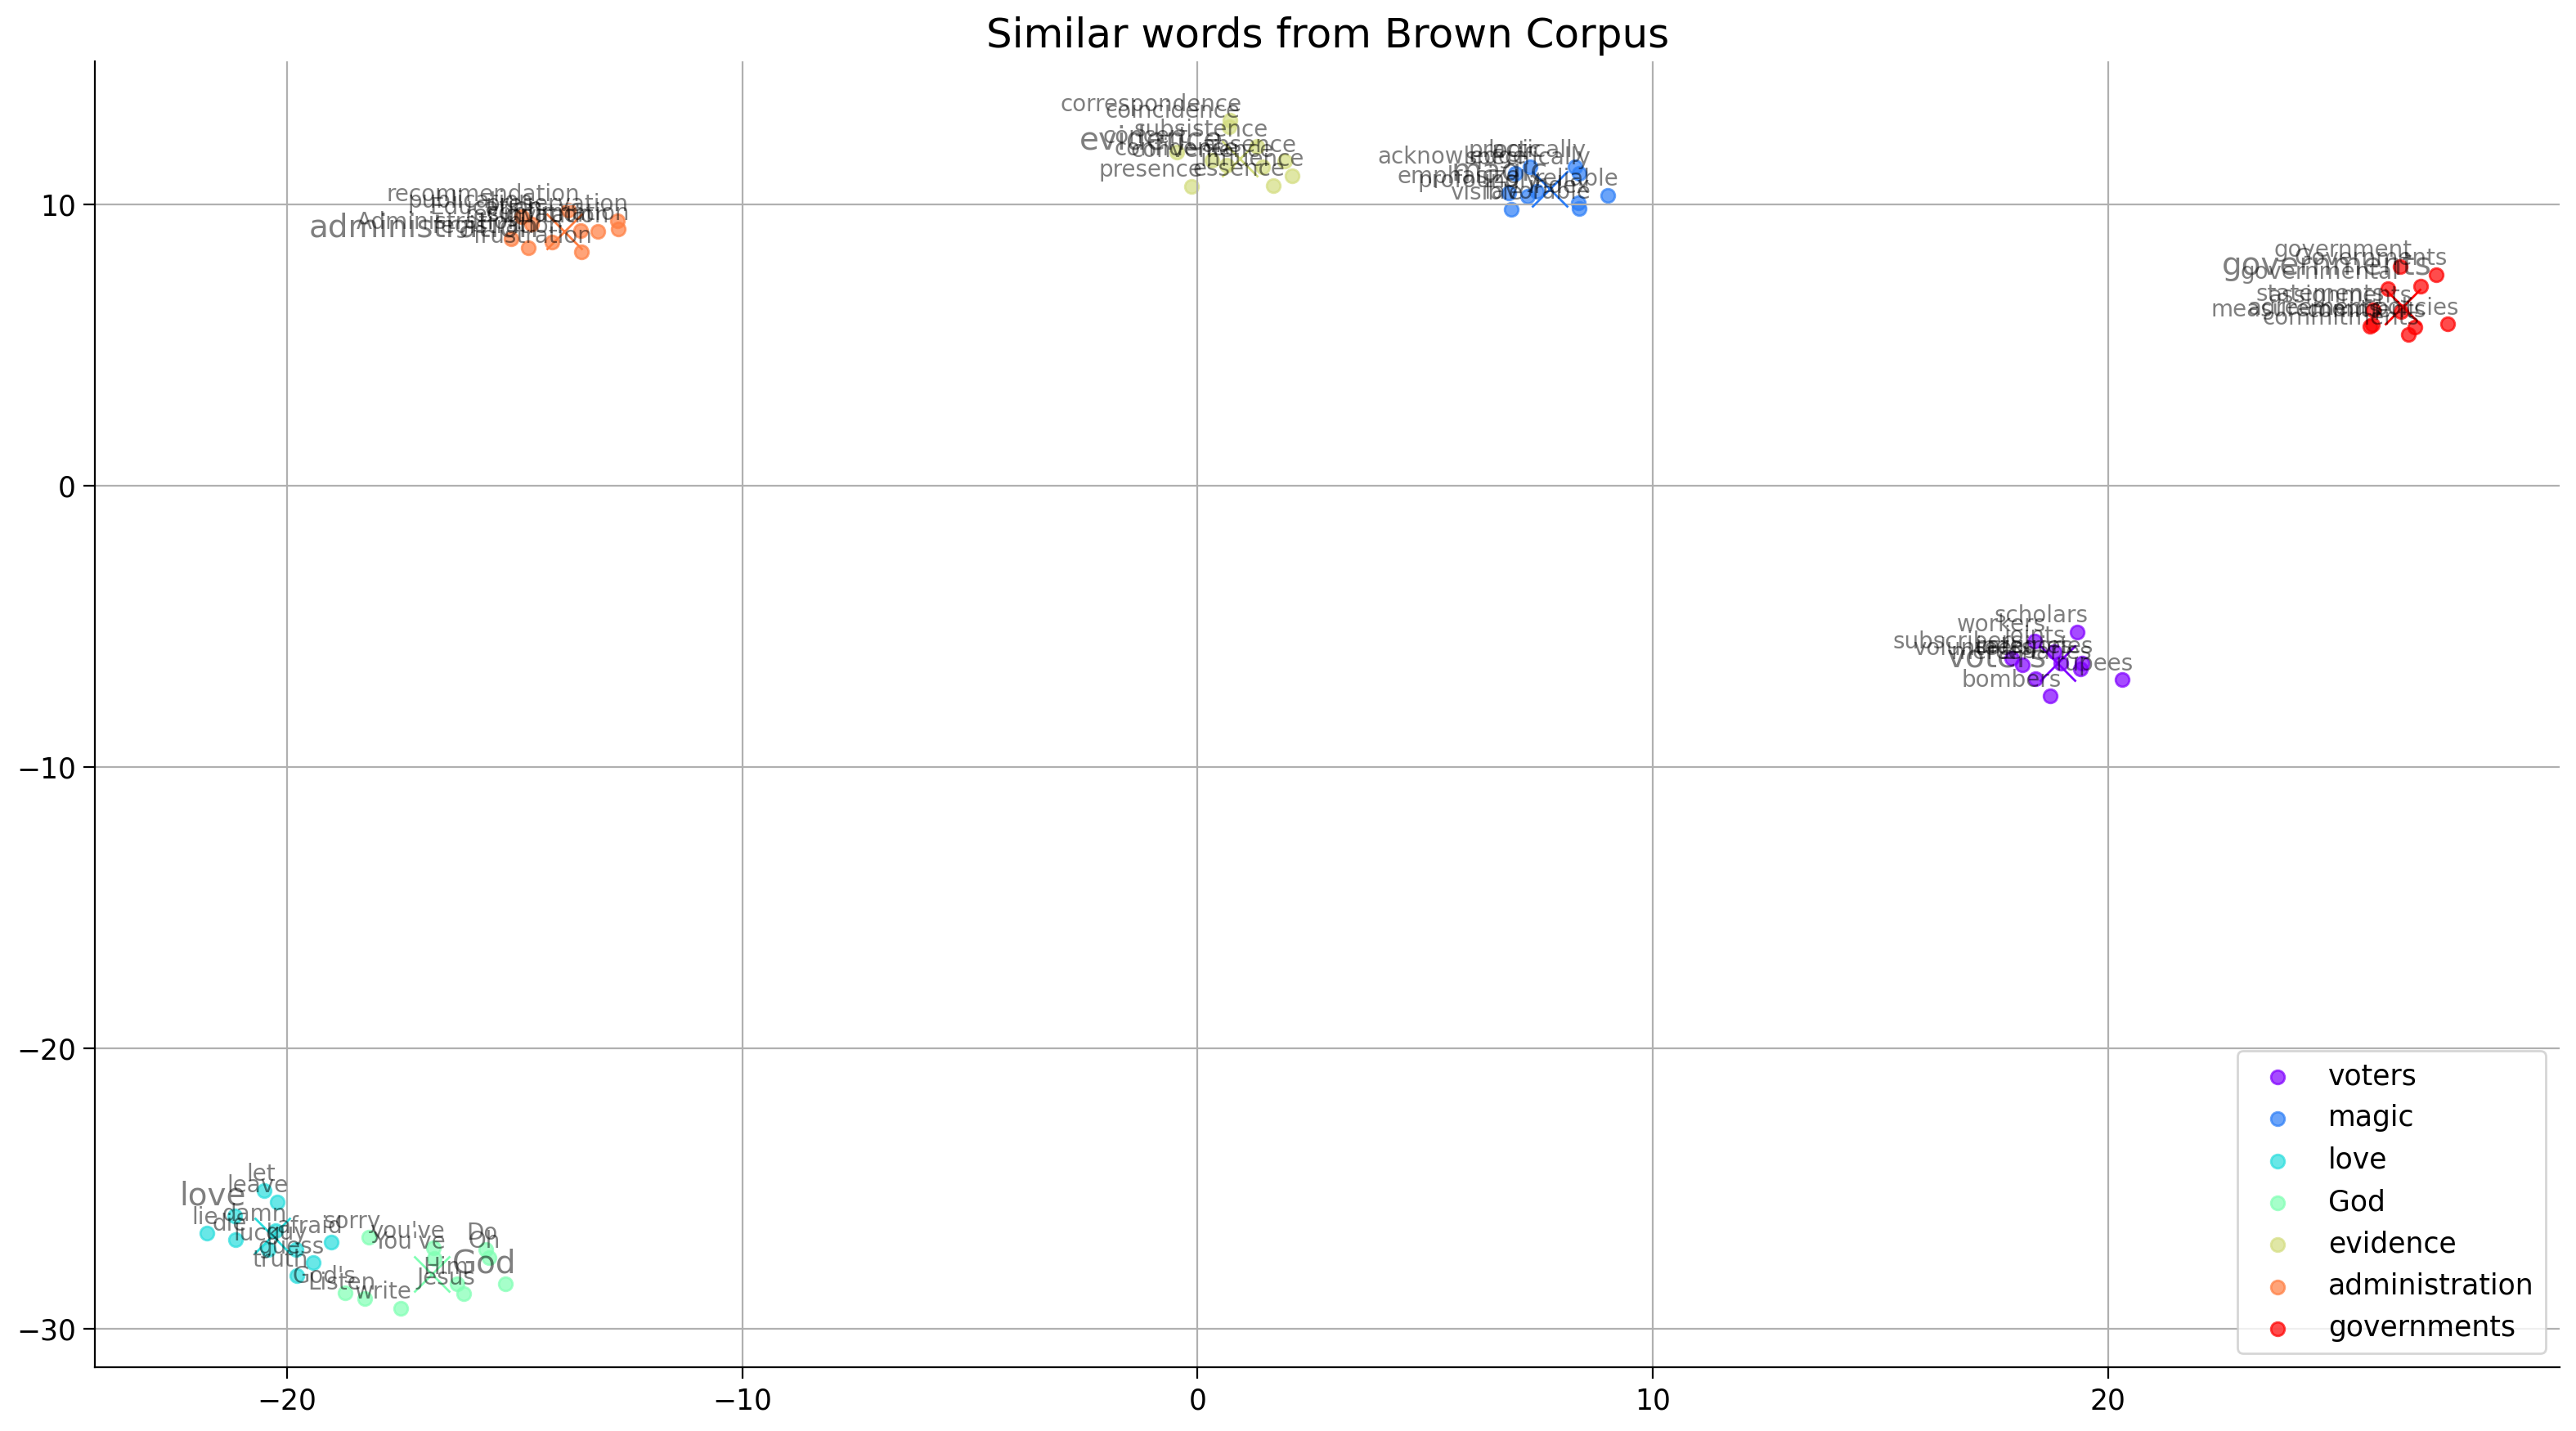

In [23]:
# Get closest words to the keys and get clusters of these words
embeddings_en_2d, word_clusters = get_cluster_embeddings(keys)
# tSNE plot of similar words to keys
tsne_plot_similar_words(title='Similar words from Brown Corpus',
                        labels=keys,
                        embedding_clusters=embeddings_en_2d,
                        word_clusters=word_clusters,
                        opacity=0.7,
                        filename='similar_words.png')

### Think! 2.1: Similarity

1. What does having higher similarity between two word embeddings mean?
2. Why are cluster centroids (represented with X in the plot) close to some keys (represented with larger fonts) but farther from others?

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content-dl/tree/main/tutorials/W3D1_TimeSeriesAndNaturalLanguageProcessing/solutions/W3D1_Tutorial1_Solution_61e9bed5.py)



In [24]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Similarity_Discussion")

## Section 2.2: Embedding exploration

In [25]:
# @title Video 4: Embeddings rule!
from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display


class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)


def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents


video_ids = [('Youtube', '7ijjjFpcOwI'), ('Bilibili', 'BV1KN4y1G7sL')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

In [26]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Embeddings_rule_Video")

In [27]:
# @title Video 5: Distributional Similarity and Vector Embeddings
from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display


class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)


def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents


video_ids = [('Youtube', '0vTuEIAnrII'), ('Bilibili', 'BV1sa411W7ks')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

In [28]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Distributional_Similarity_and_Vector_Embeddings_Video")

Words or subword units such as morphemes are the basic units we use to express meaning in language. The technique of mapping words to vectors of real numbers is known as word embedding.

In this section, we will use pretrained `fastText` embeddings, a context-oblivious embedding similar to `word2vec`.

### Embedding Manipulation

Let's use the [FastText](https://fasttext.cc/) library to manipulate the embeddings. First, find the embedding for the word "King"

In [29]:
# @markdown ### Download FastText English Embeddings of dimension 100
# @markdown This will take 1-2 minutes to run

import os, zipfile, requests

url = "https://osf.io/2frqg/download"
fname = "cc.en.100.bin.gz"

print('Downloading Started...')
# Downloading the file by sending the request to the URL
r = requests.get(url, stream=True)

# Writing the file to the local file system
with open(fname, 'wb') as f:
  f.write(r.content)
print('Downloading Completed.')

# opening the zip file in READ mode
with zipfile.ZipFile(fname, 'r') as zipObj:
  # extracting all the files
  print('Extracting all the files now...')
  zipObj.extractall()
  print('Done!')
  os.remove(fname)

Extracting all the files now...
Done!


In [30]:
# Load 100 dimension FastText Vectors using FastText library
ft_en_vectors = fasttext.load_model('cc.en.100.bin')
print(f"Length of the embedding is: {len(ft_en_vectors.get_word_vector('king'))}")
print(f"\nEmbedding for the word King is:\n {ft_en_vectors.get_word_vector('king')}")

Length of the embedding is: 100

Embedding for the word King is:
 [-0.04045481 -0.10617249 -0.27222311  0.06879666  0.16408321  0.00276707
  0.27080125 -0.05805573 -0.31865698  0.03748008 -0.00254088  0.13805169
 -0.00182498 -0.08973497  0.00319015 -0.19619396 -0.09858181 -0.10103802
 -0.08279888  0.0082208   0.13119364 -0.15956607  0.17203182  0.0315701
 -0.25064597  0.06182072  0.03929246  0.05157393  0.03543638  0.13660161
  0.05473648  0.06072914 -0.04709269  0.17394426 -0.02101276 -0.11402624
 -0.24489872 -0.08576579 -0.00322696 -0.04509873 -0.00614253 -0.05772085
 -0.073414   -0.06718913 -0.06057961  0.10963406  0.1245006  -0.04819863
  0.11408057  0.11081408  0.06752145 -0.01689911 -0.01186301 -0.11716368
 -0.01287614  0.10639337 -0.04243141  0.01057278 -0.0230855  -0.04930984
  0.04717607  0.03696446  0.0015999  -0.02193867 -0.01331578  0.11102925
  0.1686794   0.05814958 -0.00296521 -0.04252011 -0.00352389  0.06267346
 -0.07747819 -0.08959802 -0.02445797 -0.08913022  0.1342223

Cosine similarity is used for similarities between words. Similarity is a scalar between 0 and 1. Higher scalar value corresponds to higher similarity.

Now find the 10 most similar words to "king".

In [31]:
ft_en_vectors.get_nearest_neighbors("king", 10)  # Most similar by key

[(0.8168574571609497, 'prince'),
 (0.796097457408905, 'emperor'),
 (0.7907207608222961, 'kings'),
 (0.7655220627784729, 'lord'),
 (0.7435404062271118, 'king-'),
 (0.7394551634788513, 'chieftain'),
 (0.7307553291320801, 'tyrant'),
 (0.7226710319519043, 'conqueror'),
 (0.719561755657196, 'kingly'),
 (0.718187689781189, 'queen')]

### Word Similarity

More on similarity between words. Let's check how similar different pairs of word are.

In [32]:
def cosine_similarity(vec_a, vec_b):
  """Compute cosine similarity between vec_a and vec_b"""
  return np.dot(vec_a, vec_b) / (np.linalg.norm(vec_a) * np.linalg.norm(vec_b))


def getSimilarity(word1, word2):
  v1 = ft_en_vectors.get_word_vector(word1)
  v2 = ft_en_vectors.get_word_vector(word2)
  return cosine_similarity(v1, v2)


print(f"Similarity between the words King and Queen: {getSimilarity('king', 'queen')}")
print(f"Similarity between the words King and Knight: {getSimilarity('king', 'knight')}")
print(f"Similarity between the words King and Rock: {getSimilarity('king', 'rock')}")
print(f"Similarity between the words King and Twenty: {getSimilarity('king', 'twenty')}")

print(f"\nSimilarity between the words Dog and Cat: {getSimilarity('dog', 'cat')}")
print(f"Similarity between the words Ascending and Descending: {getSimilarity('ascending', 'descending')}")
print(f"Similarity between the words Victory and Defeat: {getSimilarity('victory', 'defeat')}")
print(f"Similarity between the words Less and More: {getSimilarity('less', 'more')}")
print(f"Similarity between the words True and False: {getSimilarity('true', 'false')}")

Similarity between the words King and Queen: 0.7181877493858337
Similarity between the words King and Knight: 0.6881008744239807
Similarity between the words King and Rock: 0.2892838716506958
Similarity between the words King and Twenty: 0.19655467569828033

Similarity between the words Dog and Cat: 0.833964467048645
Similarity between the words Ascending and Descending: 0.8707448840141296
Similarity between the words Victory and Defeat: 0.7478055953979492
Similarity between the words Less and More: 0.8461978435516357
Similarity between the words True and False: 0.595384955406189


### Interactive Demo 2.2.1: Check similarity between words

In [33]:
# @markdown Type two words and run the cell!
word1 = 'King'  # @param \ {type:"string"}
word2 = 'Frog'  # @param \ {type:"string"}
word_similarity = getSimilarity(word1, word2)
print(f'Similarity between {word1} and {word2}: {word_similarity}')

Similarity between King and Frog: 0.5649225115776062


Using embeddings, we can find the words that appear in similar contexts. But, what happens if the word has several different meanings?

### Homonym Similarity

Homonyms are words that have the same spelling or pronunciation but different meanings depending on the context. Let's explore how these words are embedded and their similarity in different contexts.

In [34]:
#######################     Words with multiple meanings     ##########################
print(f"Similarity between the words Cricket and Insect: {getSimilarity('cricket', 'insect')}")
print(f"Similarity between the words Cricket and Sport: {getSimilarity('cricket', 'sport')}")

Similarity between the words Cricket and Insect: 0.4072215259075165
Similarity between the words Cricket and Sport: 0.5812374353408813


In [35]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Check_similarity_between_words_Interactive_Demo")

### Interactive Demo 2.2.2: Explore homonyms

In [36]:
# @markdown Type the words and run the cell!
# @markdown examples - minute (time/small), pie (graph/food)

word = 'minute'  # @param \ {type:"string"}
context_word_1 = 'time'  # @param \ {type:"string"}
context_word_2 = 'small'  # @param \ {type:"string"}
word_similarity_1 = getSimilarity(word, context_word_1)
word_similarity_2 = getSimilarity(word, context_word_2)
print(f'Similarity between {word} and {context_word_1}: {word_similarity_1}')
print(f'Similarity between {word} and {context_word_2}: {word_similarity_2}')

Similarity between minute and time: 0.7297980785369873
Similarity between minute and small: 0.340322345495224


### Word Analogies

Embeddings can be used to find word analogies.
Let's try it:
1.   Man : Woman  ::  King : _____
2.  Germany: Berlin :: France : _____
3.  Leaf : Tree  ::  Petal : _____





In [37]:
## Use get_analogies() funnction.
# The words have to be in the order Positive, negative,  Positve

# Man : Woman  ::  King : _____
# Positive=(woman, king), Negative=(man)
print(ft_en_vectors.get_analogies("woman", "man", "king", 1))

# Germany: Berlin :: France : ______
# Positive=(berlin, frannce), Negative=(germany)
print(ft_en_vectors.get_analogies("berlin", "germany", "france", 1))

# Leaf : Tree  ::  Petal : _____
# Positive=(tree, petal), Negative=(leaf)
print(ft_en_vectors.get_analogies("tree", "leaf", "petal", 1))

[(0.8162637948989868, 'queen')]
[(0.8568049669265747, 'paris')]
[(0.7037209272384644, 'flower')]


But, does it always work?


1.   Poverty : Wealth  :: Sickness : _____
2.   train : board :: horse : _____

In [38]:
# Poverty : Wealth  :: Sickness : _____
print(ft_en_vectors.get_analogies("wealth", "poverty", "sickness", 1))

# train : board :: horse : _____
print(ft_en_vectors.get_analogies("board", "train", "horse", 1))

[(0.615874171257019, 'affliction')]
[(0.5437814593315125, 'bull')]


In [39]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Explore_homonyms_Interactive_Demo")

## Section 2.3: Neural Net with word embeddings

In [40]:
# @title Video 6: Using Embeddings
from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display


class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)


def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents


video_ids = [('Youtube', '9ujUgNoPeF0'), ('Bilibili', 'BV1cU4y1Q7Fh')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

In [41]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Using_Embeddings_Video")

Training context-oblivious word embeddings is relatively cheap, but most people still use pre-trained word embeddings. After we cover context-sensitive word embeddings, we'll see how to "fine tune" embeddings (adjust them to the task at hand).

Let's use the pretrained FastText embeddings to train a neural network on the IMDB dataset.

The data consists of reviews and sentiments attached to it, and it is a binary classification task.

###  Coding Exercise 1: Simple feed forward net

Define a vanilla neural network with linear layers. Then average the word embeddings to get an embedding for the entire review. The neural net will have one hidden layer of size 128.

In [42]:
class NeuralNet(nn.Module):
  """ A vanilla neural network. """
  def __init__(self, output_size, hidden_size, embedding_length, word_embeddings):
    """
    Constructs a vanilla Neural Network Instance.

    Args:
      batch_size: Integer
        Specifies probability of dropout hyperparameter
      output_size: Integer
        Specifies the size of output vector
      hidden_size: Integer
        Specifies the size of hidden layer
      embedding_length: Integer
        Specifies the size of the embedding vector
      word_embeddings
        Specifies the weights to create embeddings from
        voabulary.

    Returns:
      Nothing
    """
    super(NeuralNet, self).__init__()

    self.output_size = output_size
    self.hidden_size = hidden_size
    self.embedding_length = embedding_length

    self.word_embeddings = nn.EmbeddingBag.from_pretrained(word_embeddings)
    self.word_embeddings.weight.requiresGrad = False
    self.fc1 = nn.Linear(embedding_length, hidden_size)
    self.fc2 = nn.Linear(hidden_size, output_size)
    self.init_weights()

  def init_weights(self):
      initrange = 0.5
      self.fc1.weight.data.uniform_(-initrange, initrange)
      self.fc1.bias.data.zero_()
      self.fc2.weight.data.uniform_(-initrange, initrange)
      self.fc2.bias.data.zero_()

  def forward(self, inputs, offsets):
    """
    Compute the final labels by taking tokens as input.

    Args:
      inputs: Tensor
        Tensor of tokens in the text

    Returns:
      out: Tensor
        Final prediction Tensor
    """
    embedded = self.word_embeddings(inputs, offsets)  # convert text to embeddings
    #################################################
    # Implement a vanilla neural network
    raise NotImplementedError("Neural Net `forward`")
    #################################################
    # Pass the embeddings through the neural net
    # Use ReLU as the non-linearity
    x = ...
    x = ...
    x = ...
    output = F.log_softmax(x, dim=1)
    return output

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content-dl/tree/main/tutorials/W3D1_TimeSeriesAndNaturalLanguageProcessing/solutions/W3D1_Tutorial1_Solution_99db2514.py)



In [48]:
# to_remove solution
class NeuralNet(nn.Module):
  """ A vanilla neural network. """
  def __init__(self, output_size, hidden_size, embedding_length, word_embeddings):
    """
    Constructs a vanilla Neural Network Instance.

    Args:
      batch_size: Integer
        Specifies probability of dropout hyperparameter
      output_size: Integer
        Specifies the size of output vector
      hidden_size: Integer
        Specifies the size of hidden layer
      embedding_length: Integer
        Specifies the size of the embedding vector
      word_embeddings
        Specifies the weights to create embeddings from
        voabulary.

    Returns:
      Nothing
    """
    super(NeuralNet, self).__init__()

    self.output_size = output_size
    self.hidden_size = hidden_size
    self.embedding_length = embedding_length

    self.word_embeddings = nn.EmbeddingBag.from_pretrained(word_embeddings)
    self.word_embeddings.weight.requiresGrad = False
    self.fc1 = nn.Linear(embedding_length, hidden_size)
    self.fc2 = nn.Linear(hidden_size, output_size)
    self.init_weights()

  def init_weights(self):
      initrange = 0.5
      self.fc1.weight.data.uniform_(-initrange, initrange)
      self.fc1.bias.data.zero_()
      self.fc2.weight.data.uniform_(-initrange, initrange)
      self.fc2.bias.data.zero_()

  def forward(self, inputs, offsets):
    """
    Compute the final labels by taking tokens as input.

    Args:
      inputs: Tensor
        Tensor of tokens in the text

    Returns:
      out: Tensor
        Final prediction Tensor
    """
    embedded = self.word_embeddings(inputs, offsets)  # convert text to embeddings
    # Pass the embeddings through the neural net
    # Use ReLU as the non-linearity
    x = self.fc1(embedded)
    x = F.relu(x)
    x = self.fc2(x)
    output = F.log_softmax(x, dim=1)
    return output

In [49]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Simple_feed_forward_net_Exercise")

In [50]:
# @markdown ### Helper functions

# @markdown - `train(model, dataloader)`

# @markdown - `evaluate(model,  dataloader)`

# @markdown - `load_dataset(dataset_name, device, seed, batch_size, valid_split)`

# @markdown - `plot_train_val(x, train, val, train_label, val_label, title)`


# Training
import time

def train(model, dataloader):
  model.train()
  total_acc, total_count = 0, 0
  running_loss = 0
  log_interval = 500
  start_time = time.time()

  for idx, (label, text, offsets) in enumerate(dataloader):
    optimizer.zero_grad()
    predicted_label = model(text, offsets)
    loss = criterion(predicted_label, label)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
    optimizer.step()
    total_acc += (predicted_label.argmax(1) == label).sum().item()
    total_count += label.size(0)
    if idx % log_interval == 0 and idx > 0:
      elapsed = time.time() - start_time
      print(f'| epoch {epoch:3d} | {idx:5d}/{len(dataloader):5d} batches '
            f'| accuracy {total_acc/total_count:8.3f}')

      start_time = time.time()

    running_loss += loss.item()
  return total_acc/total_count, loss


def evaluate(model, dataloader):
  model.eval()
  total_acc, total_count = 0, 0
  running_loss = 0

  with torch.no_grad():
    for idx, (label, text, offsets) in enumerate(dataloader):
      predicted_label = model(text, offsets)
      loss = criterion(predicted_label, label)
      total_acc += (predicted_label.argmax(1) == label).sum().item()
      total_count += label.size(0)
      running_loss += loss
  return total_acc/total_count, loss


def load_dataset(dataset_name, tokenizer, device='cpu', seed=0, batch_size=32, valid_split=0.7):
  def encode(samples):
    enc = tokenizer.encode_batch(samples["text"])
    return {"ids": [torch.IntTensor(e.ids) for e in enc]}

  def collate_batch(batch):
      label_list, text_list, offsets = [], [], [0]
      for sample in batch:
          label_list.append(sample["label"])
          processed_text = torch.tensor(sample["ids"], dtype=torch.int64)
          text_list.append(processed_text)
          offsets.append(processed_text.size(0))
      label_list = torch.tensor(label_list, dtype=torch.int64)
      offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
      text_list = torch.cat(text_list)
      return label_list.to(device), text_list.to(device), offsets.to(device)

  dataset = datasets.load_dataset(dataset_name)
  dataset = dataset.map(encode, batched=True)

  num_class = len(dataset["train"].features["label"].names)
  splits = dataset["train"].train_test_split(train_size=valid_split, seed=seed)
  train_dataloader = DataLoader(splits["train"], batch_size=batch_size, shuffle=True, collate_fn=collate_batch)
  valid_dataloader = DataLoader(splits["test"], batch_size=batch_size, shuffle=True, collate_fn=collate_batch)
  test_dataloader = DataLoader(dataset["test"], batch_size=batch_size, shuffle=True, collate_fn=collate_batch)

  return num_class, train_dataloader, valid_dataloader, test_dataloader


# Plotting
def plot_train_val(x, train, val, train_label, val_label, title, ylabel):
  plt.plot(x, train, label=train_label)
  plt.plot(x, val, label=val_label)
  plt.legend()
  plt.xlabel('epoch')
  plt.ylabel(ylabel)
  plt.title(title)
  plt.show()

In [51]:
# @markdown ### Download embeddings

# @markdown This will load 300 dim FastText embeddings.

# @markdown It will take around 3-4 minutes.

# embedding_fasttext = FastText('simple') # used only to load into model
url = "https://dl.fbaipublicfiles.com/fasttext/vectors-wiki/wiki.simple.vec"
fname = "fasttext.simple.300d"

print('Downloading Started...')
# Downloading the file by sending the request to the URL
r = requests.get(url, stream=True)

# Writing the file to the local file system
with open(fname, 'wb') as f:
  f.write(r.content)
print('Downloading Completed.')

# load into tensor
with open(fname, "rb") as f:
  lines = f.read().split(b"\n")

vocab_size, dim = lines[0].split(b" ")
fasttext_vectors = torch.zeros(int(vocab_size)+1, int(dim))
fasttext_vocab = dict()
idx = 0
for line in lines[1:-1]:
  entries = line.rstrip().split(b" ")
  word, entries = entries[0], entries[1:]
  fasttext_vectors[idx] = torch.tensor([float(x) for x in entries])
  fasttext_vocab[word.decode()] = idx
  idx += 1
fasttext_vocab["<unk>"] = idx
print("Vectors loaded.")

Vectors loaded.


In [52]:

tokenizer = get_tokenizer(fasttext_vocab)
num_class, train_data, valid_data, test_data = load_dataset(
  "fancyzhx/ag_news", tokenizer, device=DEVICE, seed=1, batch_size=32, valid_split=0.7
)
hidden_size = 128
embedding_length = fasttext_vectors.size(1)  # 300
model = NeuralNet(num_class, hidden_size, embedding_length, fasttext_vectors).to(DEVICE)

Map:   0%|          | 0/120000 [00:00<?, ? examples/s]

Map:   0%|          | 0/7600 [00:00<?, ? examples/s]

In [53]:
# Hyperparameters
EPOCHS = 10  # epoch
LR = 5  # learning rate
BATCH_SIZE = 64  # batch size for training

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)
total_accu = None

train_loss, val_loss = [], []
train_acc, val_acc = [], []

for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()
    accu_train, loss_train = train(model, train_data)
    accu_val, loss_val = evaluate(model, valid_data)
    train_loss.append(loss_train)
    val_loss.append(loss_val)
    train_acc.append(accu_train)
    val_acc.append(accu_val)

    if total_accu is not None and total_accu > accu_val:
      scheduler.step()
    else:
       total_accu = accu_val
    print('-' * 59)
    print('| end of epoch {:3d} | time: {:5.2f}s | '
          'valid accuracy {:8.3f} '.format(epoch,
                                           time.time() - epoch_start_time,
                                           accu_val))
    print('-' * 59)

| epoch   1 |   500/ 2625 batches | accuracy    0.789
| epoch   1 |  1000/ 2625 batches | accuracy    0.823
| epoch   1 |  1500/ 2625 batches | accuracy    0.834
| epoch   1 |  2000/ 2625 batches | accuracy    0.842
| epoch   1 |  2500/ 2625 batches | accuracy    0.847
-----------------------------------------------------------
| end of epoch   1 | time: 15.08s | valid accuracy    0.866 
-----------------------------------------------------------
| epoch   2 |   500/ 2625 batches | accuracy    0.874
| epoch   2 |  1000/ 2625 batches | accuracy    0.874
| epoch   2 |  1500/ 2625 batches | accuracy    0.876
| epoch   2 |  2000/ 2625 batches | accuracy    0.876
| epoch   2 |  2500/ 2625 batches | accuracy    0.877
-----------------------------------------------------------
| end of epoch   2 | time: 15.16s | valid accuracy    0.878 
-----------------------------------------------------------
| epoch   3 |   500/ 2625 batches | accuracy    0.882
| epoch   3 |  1000/ 2625 batches | accuracy

In [54]:
print('Checking the results of test dataset.')
accu_test, loss_test = evaluate(model, test_data)
print('test accuracy {:8.3f}'.format(accu_test))

Checking the results of test dataset.
test accuracy    0.900


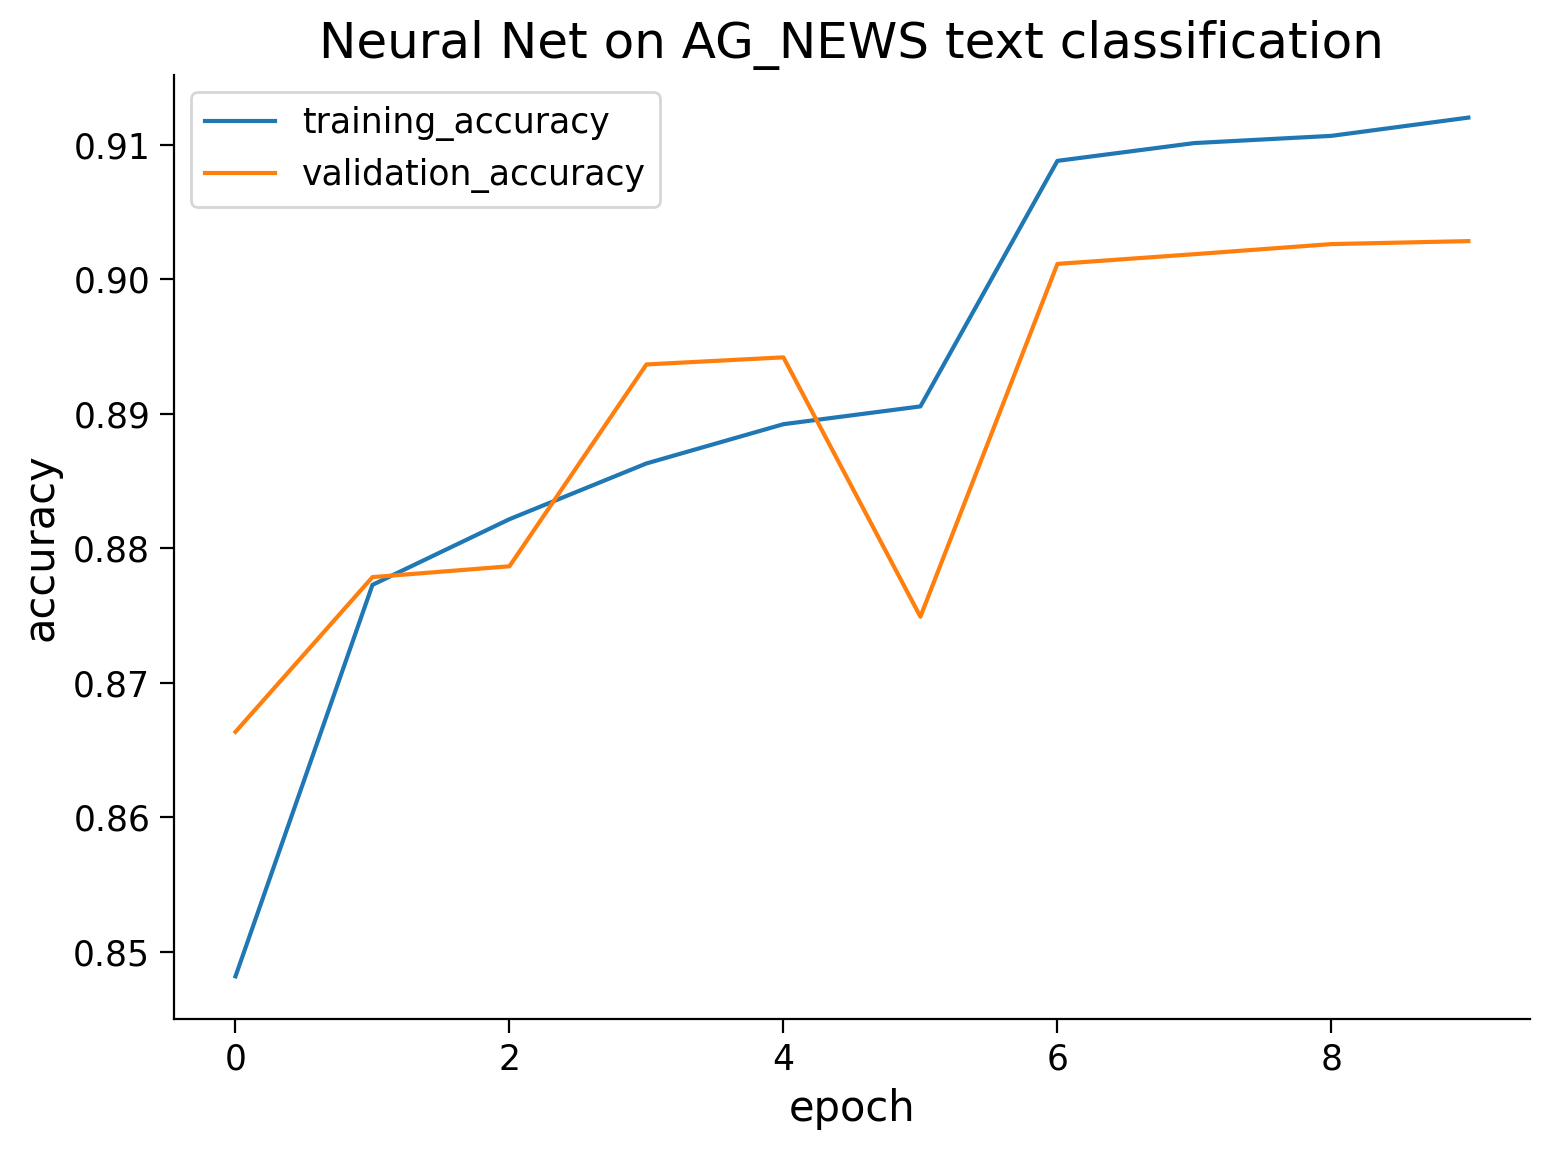

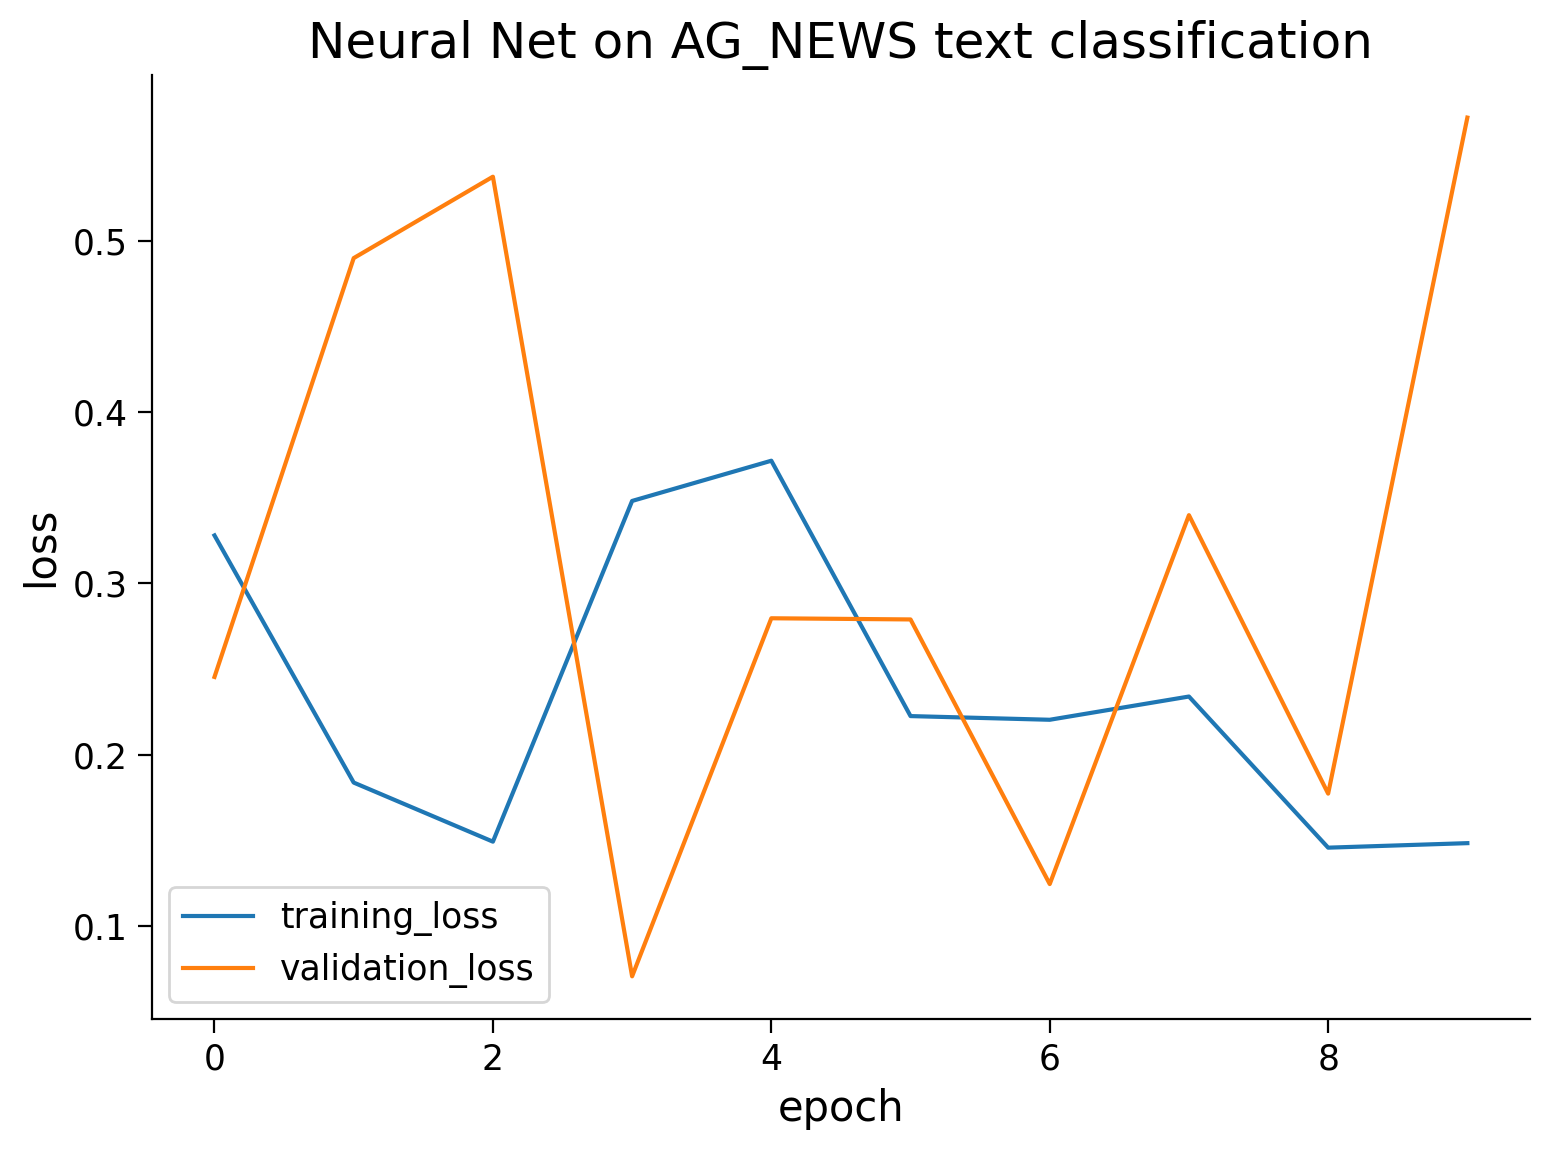

In [55]:
plot_train_val(np.arange(EPOCHS), train_acc, val_acc,
               'training_accuracy', 'validation_accuracy',
               'Neural Net on AG_NEWS text classification', 'accuracy')
plot_train_val(np.arange(EPOCHS), [x.detach().cpu().numpy() for x in train_loss],
               [x.detach().cpu().numpy() for x in val_loss],
               'training_loss', 'validation_loss',
               'Neural Net on AG_NEWS text classification', 'loss')

In [56]:
ag_news_label = {0: "World",
                 1: "Sports",
                 2: "Business",
                 3: "Sci/Tec"}

def predict(text):
  with torch.no_grad():
    text = torch.tensor(tokenizer.encode(text).ids)
    output = model(text, torch.tensor([0]))
    return output.argmax(1).item()

ex_text_str = "MEMPHIS, Tenn. – Four days ago, Jon Rahm was \
    enduring the season’s worst weather conditions on Sunday at The \
    Open on his way to a closing 75 at Royal Portrush, which \
    considering the wind and the rain was a respectable showing. \
    Thursday’s first round at the WGC-FedEx St. Jude Invitational \
    was another story. With temperatures in the mid-80s and hardly any \
    wind, the Spaniard was 13 strokes better in a flawless round. \
    Thanks to his best putting performance on the PGA Tour, Rahm \
    finished with an 8-under 62 for a three-stroke lead, which \
    was even more impressive considering he’d never played the \
    front nine at TPC Southwind."

model = model.to("cpu")

print(f"This is a {ag_news_label[predict(ex_text_str)]} news")

This is a Sports news


---
# Summary

In this tutorial, we introduced how to process time series by taking language as an example. To process time series, we should convert them into embeddings. We can first tokenize the text words and then create context-oblivious or context-dependent embeddings. Finally, we saw how these word embeddings could be processed for applications such as text classification.

<br>

If you want to learn about **Multilingual Embeddings** see the Bonus tutorial on [colab](https://colab.research.google.com/github/NeuromatchAcademy/course-content-dl/blob/main/tutorials/W3D1_TimeSeriesAndNaturalLanguageProcessing/W3D1_Tutorial3.ipynb) or [kaggle](https://kaggle.com/kernels/welcome?src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content-dl/main/tutorials/W3D1_TimeSeriesAndNaturalLanguageProcessing/W3D1_Tutorial3.ipynb). But first, we suggest completing the tutorial 2!